# Just operation policies of Guadalajara’s Aquapheric under drought conditions

## Formulation 1 plan. No uncertainties except flows
1. Define ranges of the flow under drought based on the average 2020 flow. Currently set to 0 and 150% of the average flow for all sources. L
2. Define the supplied demand ratio of each supply area + a justice as objectives (min for now)
3. Aquapheric flows as levers currently. Later Original RBFs (inputs: water flows5, outputs: AqP flows4) (not implemented)
5. Conduct an optimization (n policies, x scenarios (water flows)) This will produce a dataframe with n policies that generate n sets of objectives for each scenario.
7. Calculate an indicator of performance for each policy and each objective across all the scenarios. (average for now)
8. Visualize

### Unresolved issues
* How to visualize other outcomes when using Optimize Evaluator


In [2]:


from ema_workbench import (Model, RealParameter, ScalarOutcome,
                           MultiprocessingEvaluator, ema_logging,
                           Constant, Scenario, Constraint,optimize)


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

c:\Users\ariel\anaconda3\envs\MBWSA\lib\site-packages\ema_workbench\em_framework\evaluators.py:58: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")


In [3]:
from AMG_function import AMG_model_function
import numpy as np

outcomes = AMG_model_function(chapala_flow= 7.1, calderon_flow= 0, zapotillo_flow= 0, pozos_flow= 2.2, toluquilla_flow= 0.4, 
                aqp1_PP2_to_PP3=0.2, aqp2_PP3_to_Pozos=-0.7, aqp3_Pozos_to_Toluquilla=-0.6, aqp4_Toluquilla_to_PP1=-0.6)



print(outcomes)

pd.DataFrame(outcomes, index=[0]).to_csv("tests/validation.csv")


{'delivered_PP1': 5.751, 'delivered_PP2': 1.349, 'delivered_PP3': 0, 'delivered_Toluquilla': 0.4, 'delivered_Pozos': 2.2, 'supplied_PP1': 2.6693019600000003, 'supplied_PP2': 0.6854705, 'supplied_PP3': 0.8709999999999999, 'supplied_Toluquilla': 0.68757754, 'supplied_Pozos': 1.0504, 'total_supplied': 5.96375, 'demand_PP1': 2.93292, 'demand_PP2': 0.75717, 'demand_PP3': 0.94351, 'demand_Toluquilla': 0.78229, 'demand_Pozos': 1.20143, 'supplied_demand_PP1': 0.91012, 'supplied_demand_PP2': 0.90531, 'supplied_demand_PP3': 0.92315, 'supplied_demand_Toluquilla': 0.87893, 'supplied_demand_Pozos': 0.87429, 'supplied_demand_deficit_PP1': 0.08987999999999996, 'supplied_demand_deficit_PP2': 0.09469000000000005, 'supplied_demand_deficit_PP3': 0.07684999999999997, 'supplied_demand_deficit_Toluquilla': 0.12107000000000001, 'supplied_demand_deficit_Pozos': 0.12571, 'supply_percapita_PP1': 146.0, 'supply_percapita_PP2': 133.0, 'supply_percapita_PP3': 144.0, 'supply_percapita_Toluquilla': 130.0, 'supply_pe

# 1. Tests for a single drought scenario and no uncertainty

## 1.1 Formulation 1 with only disagregated supplied demand outcomes

In [8]:
experiments=["gini and supplied demand deficit minimization - 5k nfe.csv",
             "gini minimization and supply per capita maximization - 5k nfe.csv",
             "gini minimization and supplied demand maximization - 5k nfe.csv",
             "only GINI supplied demand optimization.csv"]

In [9]:
from AMG_function import AMG_model_function

#Setting the stage
performance_indicator_to_maximize = "supplied_demand"
performance_indicator_to_minimize = ""
info_indicator = "supplied"
justice_indicator_to_minimize = 'ZAs_below_50'
experiment_name = "tests_sufficientarian_stress_scenario"

ema_logging.log_to_stderr(ema_logging.INFO)

ZA_names = ["PP1", "PP2", "PP3", "Toluquilla", "Pozos"]

#instantiate the model
AMG_model = Model("AMGmodel", function = AMG_model_function)

#Levers

AMG_model.levers = [RealParameter('aqp1_PP2_to_PP3',-1,1),
                    RealParameter('aqp2_PP3_to_Pozos',-1,1),
                    RealParameter('aqp3_Pozos_to_Toluquilla',-1,0),
                    RealParameter('aqp4_Toluquilla_to_PP1',-1,1)]

#Outcomes


if performance_indicator_to_maximize != "":
    maximizing_outcomes = [f"{performance_indicator_to_maximize}_{ZA}" for ZA in ZA_names] #separate lists of maximizing and minizmizing objectives for simplicity
else: maximizing_outcomes = []
    
if performance_indicator_to_minimize != "":
    minimizing_outcomes = [f"{performance_indicator_to_minimize}_{ZA}" for ZA in ZA_names]
else: minimizing_outcomes = []

if info_indicator != "":
    info_outcomes = [f"{info_indicator}_{ZA}" for ZA in ZA_names]
else: info_outcomes = []


AMG_model.outcomes = [ScalarOutcome(scalar_outcome, kind=ScalarOutcome.MAXIMIZE) for scalar_outcome in maximizing_outcomes] + [
    ScalarOutcome(minimizing_outcome, kind=ScalarOutcome.MINIMIZE) for minimizing_outcome in minimizing_outcomes] + [
    ScalarOutcome(info_outcome, kind=ScalarOutcome.INFO) for info_outcome in info_outcomes] + [
        ScalarOutcome(justice_indicator_to_minimize, kind=ScalarOutcome.MINIMIZE)]



In [17]:
#Using supplied demand and a non negatyive constrain
ema_logging.log_to_stderr(ema_logging.INFO)

#Scenario setting
drougth_multiplier = 0.5
scenario1 = {"name":"test",'chapala_flow' : 6.9*drougth_multiplier, 'calderon_flow' : 1*drougth_multiplier, 'zapotillo_flow' : 1*drougth_multiplier, 'pozos_flow' : 2.3*drougth_multiplier, 'toluquilla_flow' : 0.5*drougth_multiplier}
scenario_2020 = {"name":"2020_drought",'chapala_flow' : 7.1, 'calderon_flow' : 0, 'zapotillo_flow' : 0, 'pozos_flow' : 2.2, 'toluquilla_flow' : 0.4}
scenario_sufficientarian_test = {"name":"sufficientarian_test",'chapala_flow' : 0.88, 'calderon_flow' : 1, 'zapotillo_flow' : 0.59, 'pozos_flow' : 2, 'toluquilla_flow' : 0.95}


scenario = Scenario(**scenario_sufficientarian_test)

n_outcomes = len(AMG_model.outcomes)-len(info_outcomes)


non_negative_outcomes = [f"supplied_{ZA}" for ZA in ZA_names]
constraints = [Constraint("non_negative_constrain", outcome_names= outcome, 
                         function=lambda x: max(0, -x)) for outcome in non_negative_outcomes]

with MultiprocessingEvaluator(AMG_model) as evaluator:
    results = evaluator.optimize(
        nfe=5000, searchover="levers", epsilons=[2] * n_outcomes, constraints = constraints, reference=scenario
    )


results.head(10)

[MainProcess/INFO] pool started with 8 workers
5086it [00:12, 421.25it/s]                                                     
[MainProcess/INFO] optimization completed, found 2 solutions
[MainProcess/INFO] terminating pool


,aqp1_PP2_to_PP3,aqp2_PP3_to_Pozos,aqp3_Pozos_to_Toluquilla,aqp4_Toluquilla_to_PP1,supplied_demand_PP1,supplied_demand_PP2,supplied_demand_PP3,supplied_demand_Toluquilla,supplied_demand_Pozos,ZAs_below_50
0,-0.905546,-0.403063,-0.091945,-0.572554,0.00239,0.91086,0.94810,1.23276,0.67567,1
1,0.154732,-0.992550,-0.196639,-0.562584,0.00460,0.00066,2.08465,1.13749,0.41339,2


In [20]:
import inspect
print(inspect.getsource(optimize))

def optimize(
    models,
    algorithm=EpsNSGAII,
    nfe=10000,
    searchover="levers",
    evaluator=None,
    reference=None,
    convergence=None,
    constraints=None,
    convergence_freq=1000,
    logging_freq=5,
    variator=None,
    **kwargs,
):
    """optimize the model

    Parameters
    ----------
    models : 1 or more Model instances
    algorithm : a valid Platypus optimization algorithm
    nfe : int
    searchover : {'uncertainties', 'levers'}
    evaluator : evaluator instance
    reference : Policy or Scenario instance, optional
                overwrite the default scenario in case of searching over
                levers, or default policy in case of searching over
                uncertainties
    convergence : function or collection of functions, optional
    constraints : list, optional
    convergence_freq :  int
                        nfe between convergence check
    logging_freq : int
                   number of generations between logging of progress


In [12]:
results.to_csv(f"tests/{experiment_name} with restriction.csv")

In [13]:
from data_functions import full_dataframe
full_df = full_dataframe(results,experiment_name=experiment_name, scenario=scenario)
full_df.head()

,aqp4_Toluquilla_to_PP1,aqp1_PP2_to_PP3,aqp2_PP3_to_Pozos,aqp3_Pozos_to_Toluquilla,delivered_PP1,delivered_PP2,delivered_PP3,delivered_Toluquilla,delivered_Pozos,supplied_PP1,...,supply_percapita_PP3,supply_percapita_Toluquilla,supply_percapita_Pozos,min_supplied_demand,supplied_demand_GINI,ZAs_below_128,ZAs_below_100,ZAs_below_50,scenario,experiment
0,-0.048578,-0.565818,-0.640342,-0.271520,0.7128,0.1672,1.59,0.95,2.0,0.347606,...,210.0,96.0,94.0,0.11852,0.294213,4.0,4.0,1.0,,tests_sufficientarian_stress_scenario
1,-0.381079,-0.623576,-0.430096,-0.092559,0.7128,0.1672,1.59,0.95,2.0,0.131480,...,181.0,159.0,97.0,0.04483,0.293042,3.0,3.0,1.0,,tests_sufficientarian_stress_scenario
2,-0.146018,-0.944379,0.649568,-0.658317,0.7128,0.1672,1.59,0.95,2.0,0.284269,...,31.0,60.0,227.0,0.09692,0.457652,3.0,3.0,2.0,,tests_sufficientarian_stress_scenario
3,-0.514129,-0.788510,-0.144742,-0.122185,0.7128,0.1672,1.59,0.95,2.0,0.044997,...,133.0,171.0,122.0,0.01534,0.253901,3.0,1.0,1.0,,tests_sufficientarian_stress_scenario
4,-0.079506,-0.155763,-0.767237,-0.939258,0.7128,0.1672,1.59,0.95,2.0,0.327502,...,268.0,18.0,137.0,0.11166,0.511121,3.0,3.0,3.0,,tests_sufficientarian_stress_scenario


In [ ]:
dataframe=full_df[[f"supplied_demand_{ZA}" for ZA in ZA_names]+["supplied_demand_GINI"]]

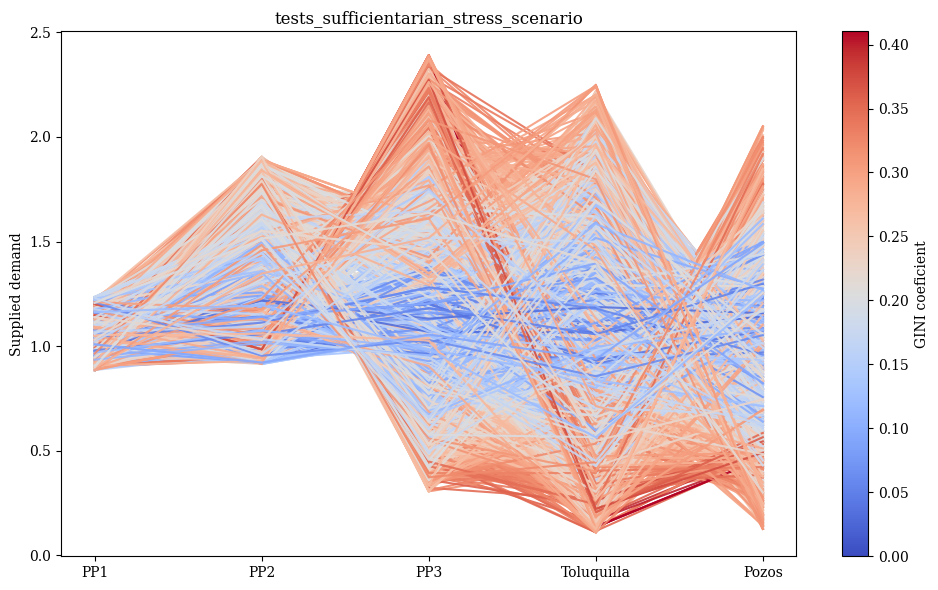

In [ ]:
from viz_functions import plot_parallel_axis

plot_parallel_axis(dataframe, experiment_name, "Supplied demand", "supplied_demand_GINI","GINI coeficient")

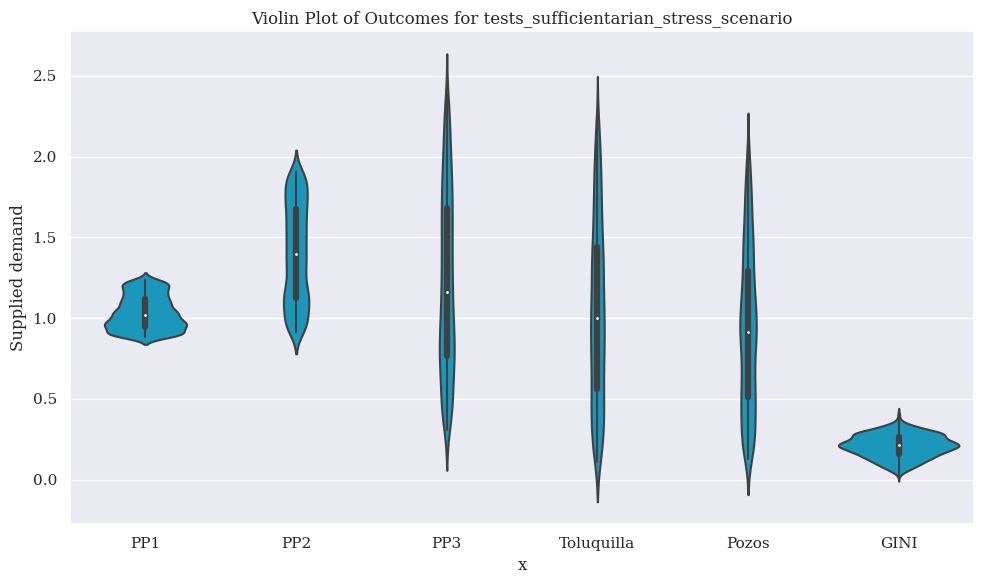

In [ ]:
from viz_functions import violin_plot

results_plot = full_df[[f"supplied_demand_{ZA}" for ZA in ZA_names]+["supplied_demand_GINI"]]
violin_plot(results_plot,experiment_name, y_axis="Supplied demand")

from viz_functions import parallel_axis_plot

parallel_axis_plot(results_plot)

In [ ]:
experiment_results = full_df


experiment_results.head()

,aqp4_Toluquilla_to_PP1,aqp1_PP2_to_PP3,aqp2_PP3_to_Pozos,aqp3_Pozos_to_Toluquilla,delivered_PP1,delivered_PP2,delivered_PP3,delivered_Toluquilla,delivered_Pozos,supplied_PP1,...,supply_percapita_PP3,supply_percapita_Toluquilla,supply_percapita_Pozos,min_supplied_demand,supplied_demand_GINI,ZAs_below_128,ZAs_below_100,ZAs_below_50,scenario,experiment
0,-0.190968,-0.437851,-0.130736,-0.467103,5.589,1.311,2.0,0.5,2.3,2.848995,...,217.0,105.0,169.0,0.71340,0.129890,1.0,0.0,0.0,,tests_sufficientarian_stress_scenario
1,-0.579233,-0.892626,0.774795,0.927590,5.589,1.311,2.0,0.5,2.3,2.596623,...,70.0,324.0,130.0,0.44957,0.283641,1.0,1.0,0.0,,tests_sufficientarian_stress_scenario
2,-0.467063,-0.997807,-0.646072,0.697159,5.589,1.311,2.0,0.5,2.3,2.669534,...,212.0,282.0,36.0,0.24388,0.273625,1.0,1.0,1.0,,tests_sufficientarian_stress_scenario
3,-0.319646,-0.704369,0.510010,-0.707072,5.589,1.311,2.0,0.5,2.3,2.765355,...,119.0,92.0,239.0,0.62093,0.208937,2.0,1.0,0.0,,tests_sufficientarian_stress_scenario
4,0.906089,-0.320688,-0.828058,0.382219,5.589,1.311,2.0,0.5,2.3,3.562082,...,304.0,75.0,46.0,0.31581,0.307360,2.0,2.0,1.0,,tests_sufficientarian_stress_scenario


In [ ]:
experiment_results = full_df.drop(full_df.index, inplace=False)
experiment_results.head()

,aqp4_Toluquilla_to_PP1,aqp1_PP2_to_PP3,aqp2_PP3_to_Pozos,aqp3_Pozos_to_Toluquilla,delivered_PP1,delivered_PP2,delivered_PP3,delivered_Toluquilla,delivered_Pozos,supplied_PP1,...,supply_percapita_PP3,supply_percapita_Toluquilla,supply_percapita_Pozos,min_supplied_demand,supplied_demand_GINI,ZAs_below_128,ZAs_below_100,ZAs_below_50,scenario,experiment


In [ ]:
experiments=["gini and supplied demand deficit minimization - 5k nfe.csv",
             "gini minimization and supply per capita maximization - 5k nfe.csv",
             "gini minimization and supplied demand maximization - 5k nfe.csv",
             "only GINI supplied demand optimization.csv"]

experiment_results = full_df.drop(full_df.index, inplace=False)

for experiment in experiments:
    df=pd.read_csv(f"experiment_results/{experiment}")
    print(df.columns[-6:])
    experiment_results=pd.concat([experiment_results,df])#

experiment_results.tail()

Index(['supply_percapita_Pozos', 'min_supplied_demand', 'min_deficit_sq',
       'supplied_demand_GINI', 'experiment', 'scenario'],
      dtype='object')
Index(['supply_percapita_Pozos', 'min_supplied_demand', 'min_deficit_sq',
       'supplied_demand_GINI', 'experiment', 'scenario'],
      dtype='object')
Index(['supply_percapita_Pozos', 'min_supplied_demand', 'min_deficit_sq',
       'supplied_demand_GINI', 'experiment', 'scenario'],
      dtype='object')
Index(['supply_percapita_Pozos', 'min_supplied_demand', 'min_deficit_sq',
       'supplied_demand_GINI', 'experiment', 'scenario'],
      dtype='object')


,aqp4_Toluquilla_to_PP1,aqp1_PP2_to_PP3,aqp2_PP3_to_Pozos,aqp3_Pozos_to_Toluquilla,delivered_PP1,delivered_PP2,delivered_PP3,delivered_Toluquilla,delivered_Pozos,supplied_PP1,...,supply_percapita_Pozos,min_supplied_demand,supplied_demand_GINI,ZAs_below_128,ZAs_below_100,ZAs_below_50,scenario,experiment,Unnamed: 0,min_deficit_sq
1886,-0.989297,0.178666,-0.683449,0.901822,5.751,1.349,0.0,0.4,2.2,2.416259,...,10.0,0.07073,0.376252,NaN,NaN,NaN,2020_drought,gini minimization and supplied demand maximiza...,1886.0,0.00334
1887,0.450793,0.591937,-0.778967,0.864791,5.751,1.349,0.0,0.4,2.2,3.352317,...,6.0,0.03908,0.290997,NaN,NaN,NaN,2020_drought,gini minimization and supplied demand maximiza...,1887.0,0.03041
1888,-0.484399,0.803595,0.839958,0.757744,5.751,1.349,0.0,0.4,2.2,2.744443,...,143.0,0.27807,0.343524,NaN,NaN,NaN,2020_drought,gini minimization and supplied demand maximiza...,1888.0,0.00106
1889,-0.417371,-0.023318,-0.819881,-0.605251,5.751,1.349,0.0,0.4,2.2,2.788011,...,119.0,0.72282,0.079982,NaN,NaN,NaN,2020_drought,gini minimization and supplied demand maximiza...,1889.0,0.00540
0,-0.669592,0.195002,-0.684482,-0.635428,5.751,1.349,0.0,0.4,2.2,2.624067,...,132.0,0.89469,0.003272,NaN,NaN,NaN,2020_drought,only GINI supplied demand optimization,0.0,0.00469


In [ ]:
dataframe= experiment_results[[f"supplied_demand_{ZA}" for ZA in ZA_names]+["supplied_demand_GINI"]+["experiment"]]
dataframe.tail()

,supplied_demand_PP1,supplied_demand_PP2,supplied_demand_PP3,supplied_demand_Toluquilla,supplied_demand_Pozos,supplied_demand_GINI,experiment
1886,0.82384,0.92362,0.89705,2.45025,0.07073,0.376252,gini minimization and supplied demand maximiza...
1887,1.14300,0.56884,1.24756,1.22292,0.03908,0.290997,gini minimization and supplied demand maximiza...
1888,0.93574,0.38714,0.27807,1.91102,0.97287,0.343524,gini minimization and supplied demand maximiza...
1889,0.95059,1.09702,0.85189,0.72282,0.81227,0.079982,gini minimization and supplied demand maximiza...
0,0.89469,0.90960,0.90902,0.90732,0.90185,0.003272,only GINI supplied demand optimization


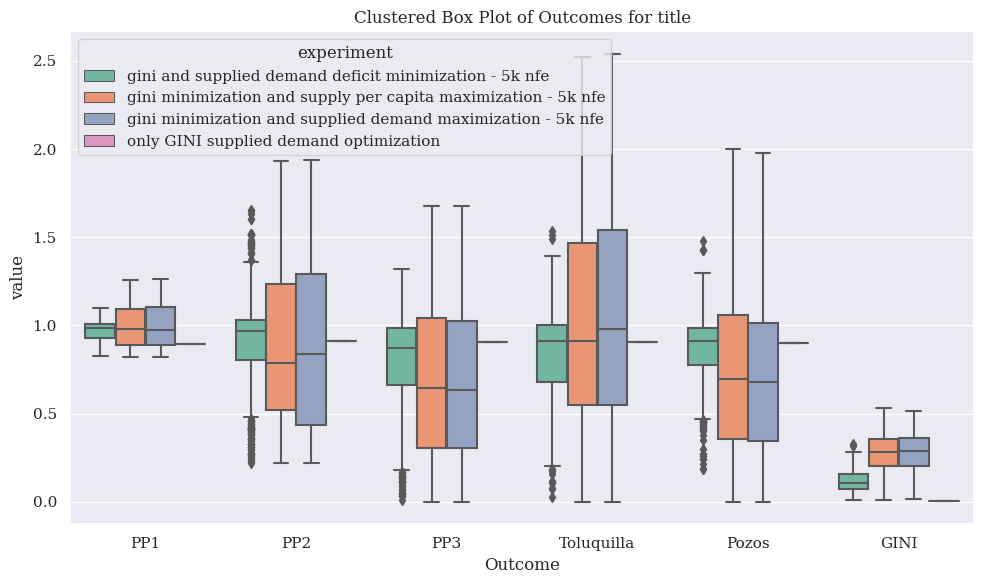

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select columns for the DataFrame
dataframe = experiment_results[[f"supplied_demand_{ZA}" for ZA in ZA_names] + ["supplied_demand_GINI", "experiment"]]

# Create a DataFrame with the necessary columns
viz_data = dataframe.rename(columns=lambda x: x.split('_')[-1])

# Melt the DataFrame to long format for plotting
viz_data_melted = viz_data.melt(id_vars=['experiment'], var_name='Outcome')

# Create the clustered box plot with customized parameters
plt.figure(figsize=(10, 6))
sns.boxplot(x='Outcome', y='value', hue='experiment', data=viz_data_melted, palette='Set2')
plt.title('Clustered Box Plot of Outcomes for {}'.format("title"))
plt.tight_layout()

# Show the plot
plt.savefig("experiment_results/experiments_boxplot.png")
plt.show()



In [ ]:
from viz_functions import clustered_box_plot

clustered_box_plot(experiment_results)

TypeError: Neither the `x` nor `y` variable appears to be numeric.

<Figure size 1000x600 with 0 Axes>

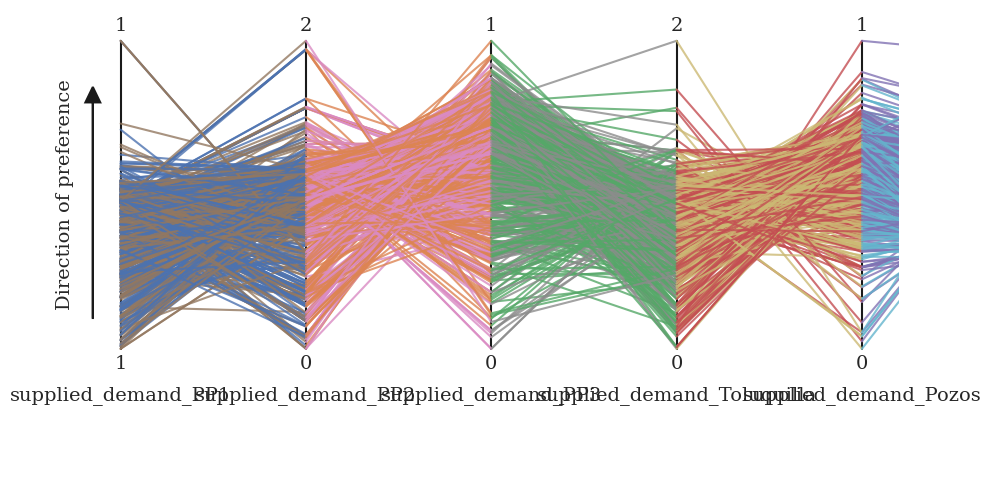

In [ ]:
### function to normalize data based on direction of preference and whether each objective is minimized or maximized
###   -> output dataframe will have values ranging from 0 (which maps to bottom of figure) to 1 (which maps to top)
def reorganize_objs(objs, columns_axes, ideal_direction, minmaxs):
    ### if min/max directions not given for each axis, assume all should be maximized
    if minmaxs is None:
        minmaxs = ['max']*len(columns_axes)
         
    ### get subset of dataframe columns that will be shown as parallel axes
    objs_reorg = objs[columns_axes]
     
    ### reorganize & normalize data to go from 0 (bottom of figure) to 1 (top of figure), 
    ### based on direction of preference for figure and individual axes
    if ideal_direction == 'bottom':
        tops = objs_reorg.min(axis=0)
        bottoms = objs_reorg.max(axis=0)
        for i, minmax in enumerate(minmaxs):
            if minmax == 'max':
                objs_reorg.iloc[:, i] = (objs_reorg.iloc[:, i].max(axis=0) - objs_reorg.iloc[:, i]) / \
                                        (objs_reorg.iloc[:, i].max(axis=0) - objs_reorg.iloc[:, i].min(axis=0))
            else:
                bottoms[i], tops[i] = tops[i], bottoms[i]
                objs_reorg.iloc[:, -1] = (objs_reorg.iloc[:, -1] - objs_reorg.iloc[:, -1].min(axis=0)) / \
                                         (objs_reorg.iloc[:, -1].max(axis=0) - objs_reorg.iloc[:, -1].min(axis=0))
    elif ideal_direction == 'top':
        tops = objs_reorg.max(axis=0)
        bottoms = objs_reorg.min(axis=0)
        for i, minmax in enumerate(minmaxs):
            if minmax == 'max':
                objs_reorg.iloc[:, i] = (objs_reorg.iloc[:, i] - objs_reorg.iloc[:, i].min(axis=0)) / \
                                        (objs_reorg.iloc[:, i].max(axis=0) - objs_reorg.iloc[:, i].min(axis=0))
            else:
                bottoms[i], tops[i] = tops[i], bottoms[i]
                objs_reorg.iloc[:, i] = (objs_reorg.iloc[:, i].max(axis=0) - objs_reorg.iloc[:, i]) / \
                                        (objs_reorg.iloc[:, i].max(axis=0) - objs_reorg.iloc[:, i].min(axis=0))
 
    return objs_reorg, tops, bottoms

### function to get color based on continuous color map or categorical map
def get_color(value, color_by_continuous, color_palette_continuous, 
              color_by_categorical, color_dict_categorical):
    if color_by_continuous is not None:
        color = colormaps.get_cmap(color_palette_continuous)(value)
    elif color_by_categorical is not None:
        color = color_dict_categorical[value]
    return color

### function to get zorder value for ordering lines on plot. 
### This works by binning a given axis' values and mapping to discrete classes.
def get_zorder(norm_value, zorder_num_classes, zorder_direction):
    xgrid = np.arange(0, 1.001, 1/zorder_num_classes)
    if zorder_direction == 'ascending':
        return 4 + np.sum(norm_value > xgrid)
    elif zorder_direction == 'descending':
        return 4 + np.sum(norm_value < xgrid)

def custom_parallel_coordinates(objs, columns_axes=None, axis_labels=None, 
                                ideal_direction='top', minmaxs=None, 
                                color_by_continuous=None, color_palette_continuous=None, 
                                color_by_categorical=None, color_palette_categorical=None,
                                colorbar_ticks_continuous=None, color_dict_categorical=None,
                                zorder_by=None, zorder_num_classes=10, zorder_direction='ascending', 
                                alpha_base=0.8, brushing_dict=None, alpha_brush=0.05, 
                                lw_base=1.5, fontsize=14, 
                                figsize=(11,6), save_fig_filename=None):
     
    ### verify that all inputs take supported values
    assert ideal_direction in ['top','bottom']
    assert zorder_direction in ['ascending', 'descending']
    if minmaxs is not None:
        for minmax in minmaxs:
            assert minmax in ['max','min']
    assert color_by_continuous is None or color_by_categorical is None
    if columns_axes is None:
        columns_axes = objs.columns
    if axis_labels is None:
        axis_labels = columns_axes
     
    ### create figure
    fig,ax = plt.subplots(1,1,figsize=figsize, gridspec_kw={'hspace':0.1, 'wspace':0.1})
 
    ### reorganize & normalize objective data
    objs_reorg, tops, bottoms = reorganize_objs(objs, columns_axes, ideal_direction, minmaxs)
 
    ### apply any brushing criteria
    if brushing_dict is not None:
        satisfice = np.zeros(objs.shape[0]) == 0.
        ### iteratively apply all brushing criteria to get satisficing set of solutions
        for col_idx, (threshold, operator) in brushing_dict.items():
            if operator == '<':
                satisfice = np.logical_and(satisfice, objs.iloc[:,col_idx] < threshold)
            elif operator == '<=':
                satisfice = np.logical_and(satisfice, objs.iloc[:,col_idx] <= threshold)
            elif operator == '>':
                satisfice = np.logical_and(satisfice, objs.iloc[:,col_idx] > threshold)
            elif operator == '>=':
                satisfice = np.logical_and(satisfice, objs.iloc[:,col_idx] >= threshold)
 
            ### add rectangle patch to plot to represent brushing
            threshold_norm = (threshold - bottoms[col_idx]) / (tops[col_idx] - bottoms[col_idx])
            if ideal_direction == 'top' and minmaxs[col_idx] == 'max':
                if operator in ['<', '<=']:
                    rect = Rectangle([col_idx-0.05, threshold_norm], 0.1, 1-threshold_norm)
                elif operator in ['>', '>=']:
                    rect = Rectangle([col_idx-0.05, 0], 0.1, threshold_norm)
            elif ideal_direction == 'top' and minmaxs[col_idx] == 'min':
                if operator in ['<', '<=']:
                    rect = Rectangle([col_idx-0.05, 0], 0.1, threshold_norm)
                elif operator in ['>', '>=']:
                    rect = Rectangle([col_idx-0.05, threshold_norm], 0.1, 1-threshold_norm)
            if ideal_direction == 'bottom' and minmaxs[col_idx] == 'max':
                if operator in ['<', '<=']:
                    rect = Rectangle([col_idx-0.05, 0], 0.1, threshold_norm)
                elif operator in ['>', '>=']:
                    rect = Rectangle([col_idx-0.05, threshold_norm], 0.1, 1-threshold_norm)
            elif ideal_direction == 'bottom' and minmaxs[col_idx] == 'min':
                if operator in ['<', '<=']:
                    rect = Rectangle([col_idx-0.05, threshold_norm], 0.1, 1-threshold_norm)
                elif operator in ['>', '>=']:
                    rect = Rectangle([col_idx-0.05, 0], 0.1, threshold_norm)
                     
            pc = PatchCollection([rect], facecolor='grey', alpha=0.5, zorder=3)
            ax.add_collection(pc)
     
    ### loop over all solutions/rows & plot on parallel axis plot
    for i in range(objs_reorg.shape[0]):
        if color_by_continuous is not None:
            color = get_color(objs_reorg[columns_axes[color_by_continuous]].iloc[i], 
                              color_by_continuous, color_palette_continuous, 
                              color_by_categorical, color_dict_categorical)
        elif color_by_categorical is not None:
            color = get_color(objs[color_by_categorical].iloc[i], 
                              color_by_continuous, color_palette_continuous, 
                              color_by_categorical, color_dict_categorical)
                         
        ### order lines according to ascending or descending values of one of the objectives?
        if zorder_by is None:
            zorder = 4
        else:
            zorder = get_zorder(objs_reorg[columns_axes[zorder_by]].iloc[i], 
                                zorder_num_classes, zorder_direction)
             
        ### apply any brushing?
        if brushing_dict is not None:
            if satisfice.iloc[i]:
                alpha = alpha_base
                lw = lw_base
            else:
                alpha = alpha_brush
                lw = 1
                zorder = 2
        else:
            alpha = alpha_base
            lw = lw_base
             
        ### loop over objective/column pairs & plot lines between parallel axes
        for j in range(objs_reorg.shape[1]-1):
            y = [objs_reorg.iloc[i, j], objs_reorg.iloc[i, j+1]]
            x = [j, j+1]
            ax.plot(x, y,  alpha=alpha, zorder=zorder, lw=lw)
             
             
    ### add top/bottom ranges
    for j in range(len(columns_axes)):
        ax.annotate(str(round(tops[j])), [j, 1.02], ha='center', va='bottom', 
                    zorder=5, fontsize=fontsize)
        if j == len(columns_axes)-1:
            ax.annotate(str(round(bottoms[j])) + '+', [j, -0.02], ha='center', va='top', 
                        zorder=5, fontsize=fontsize)    
        else:
            ax.annotate(str(round(bottoms[j])), [j, -0.02], ha='center', va='top', 
                        zorder=5, fontsize=fontsize)    
 
        ax.plot([j,j], [0,1], c='k', zorder=1)
     
    ### other aesthetics
    ax.set_xticks([])
    ax.set_yticks([])
     
    for spine in ['top','bottom','left','right']:
        ax.spines[spine].set_visible(False)
 
    if ideal_direction == 'top':
        ax.arrow(-0.15,0.1,0,0.7, head_width=0.08, head_length=0.05, color='k', lw=1.5)
    elif ideal_direction == 'bottom':
        ax.arrow(-0.15,0.9,0,-0.7, head_width=0.08, head_length=0.05, color='k', lw=1.5)
    ax.annotate('Direction of preference', xy=(-0.3,0.5), ha='center', va='center',
                rotation=90, fontsize=fontsize)
 
    ax.set_xlim(-0.4, 4.2)
    ax.set_ylim(-0.4,1.1)
     
    for i,l in enumerate(axis_labels):
        ax.annotate(l, xy=(i,-0.12), ha='center', va='top', fontsize=fontsize)
    ax.patch.set_alpha(0)
     
 
    ### colorbar for continuous legend
    if color_by_continuous is not None:
        mappable = cm.ScalarMappable(cmap=color_palette_continuous)
        mappable.set_clim(vmin=objs[columns_axes[color_by_continuous]].min(), 
                          vmax=objs[columns_axes[color_by_continuous]].max())
        cb = plt.colorbar(mappable, ax=ax, orientation='horizontal', shrink=0.4, 
                          label=axis_labels[color_by_continuous], pad=0.03, 
                          alpha=alpha_base)
        if colorbar_ticks_continuous is not None:
            _ = cb.ax.set_xticks(colorbar_ticks_continuous, colorbar_ticks_continuous, 
                                 fontsize=fontsize)
        _ = cb.ax.set_xlabel(cb.ax.get_xlabel(), fontsize=fontsize)  
    ### categorical legend
    elif color_by_categorical is not None:
        leg = []
        for label,color in color_dict_categorical.items():
            leg.append(Line2D([0], [0], color=color, lw=3, 
                              alpha=alpha_base, label=label))
        _ = ax.legend(handles=leg, loc='lower center', 
                      ncol=max(3, len(color_dict_categorical)),
                      bbox_to_anchor=[0.5,-0.07], frameon=False, fontsize=fontsize)
         
    ### save figure
    if save_fig_filename is not None:
        plt.savefig(save_fig_filename, bbox_inches='tight', dpi=300)

custom_parallel_coordinates(results_plot)

ValueError: x and y must have same first dimension, but have shapes (6,) and (735,)

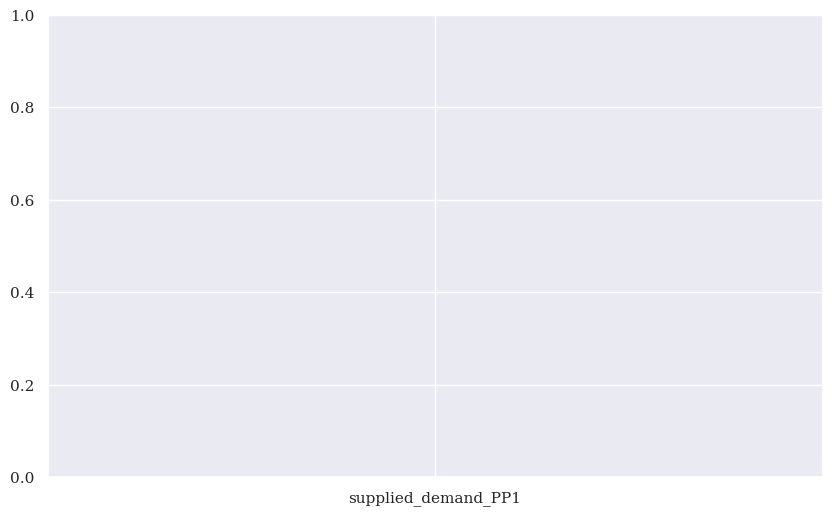

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the font to serif
sns.set(font='serif')

# Transpose the DataFrame so that rows become the axes and columns become the lines
viz_data_transposed = results_plot.T.reset_index(drop=True)

# Create the parallel axis plot with customized parameters
plt.figure(figsize=(10, 6))

# Get the x-axis data (column names)
x_data = results_plot.columns

# Iterate through each row (line) in the transposed dataframe
for index, row in viz_data_transposed.iterrows():
    # Plot the line
    plt.plot(x_data, row, label=index)
    
# Set plot title and labels
plt.title('Parallel Axis Plot')
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()




## 1.2 Formulation with supplied demand deficit

## 1.2 Formulation 2 with squared deficits outcomes

## 2. Single scenario with uncertainty (not implemented)


# 3. Multiple drought scenarios, no uncerainty (not implemented)


# Robust optimization


In [ ]:
'''#define a multiplier for all the water flows based on the average 2020 flow that represents drought and possible compensation by other sources
low_flow=0
high_flow=0.7

AMG_model.uncertainties = [RealParameter('chapala_flow',low_flow,6.3*high_flow),
                           RealParameter('calderon_flow',low_flow,1*high_flow),
                           RealParameter('zapotillo_flow',low_flow,1*high_flow),
                           RealParameter('pozos_flow',low_flow,0.5*high_flow),
                           RealParameter('toluquilla_flow',low_flow,1*high_flow)]
                           
                           
,chapala_flow = 6.9, calderon_flow = 1, zapotillo_flow = 1, pozos_flow = 2.3, toluquilla_flow = 0.5'''

